In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from scripts.dataset_explorer import SODataSetExplorer
from scripts.feature_handler import DevTypeHandler, CompensationHandler
from scripts.developer_type_labeling import selected_dev_type_columns

In [3]:
import plotly.express as px
import plotly
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [4]:
import chart_studio
import chart_studio.plotly as py
import os

chart_studio_apikey = os.getenv('CHART_STUDIO_API_KEY')
chart_studio.tools.set_credentials_file(username='masharo', api_key=chart_studio_apikey)

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Load datasets

In [6]:
year_range = list(range(2018, 2021))
df_explorer = SODataSetExplorer(year_range)

## Business Understanding Questions
* From the last 3 years (2018-2020), how does developers' compensation has changed?
* Which developer type has the highest compensation on average?

## Data Understanding

### Developer Type

* Display similar columns

In [115]:
df_explorer.similar_columns(['occupation', 'dev_type', 'developer_type'], years=[2018,2019,2020]);

2018
{'dev_type'}


2019
{'dev_type'}


2020
{'dev_type'}




Since we'll be analysing the last three year compensation evolution we'll use the `dev_type` feature without merging the other years.

* Feature type

In [112]:
df_explorer.datasets[2020][['dev_type']].head()

,dev_type
0,"Developer, desktop or enterprise applications;Developer, full-stack"
1,"Developer, full-stack;Developer, mobile"
2,NaN
3,NaN
4,NaN


* Missing values

In [113]:
df_explorer.missing_values_percentage('dev_type')

,year,dev_type
0,2018,0.068353
1,2019,0.084921
2,2020,0.234111


### Compensation

* Display similar columns

In [116]:
df_explorer.similar_columns(['comp', 'salary'], years=[2018,2019,2020]);

2018
{'company_size', 'salary_type', 'compensation', 'salary', 'hours_computer'}


2019
{'comp_freq', 'comp_total', 'compensation'}


2020
{'comp_freq', 'comp_total', 'compensation'}




* Rename feature into `compensation`

In [11]:
compensation_feature = 'compensation'
by_year_col_rename = {
    'new_column_name': compensation_feature,
    'year_map': {
        2018: 'converted_salary',
        2019: 'converted_comp',
        2020: 'converted_comp'
    }
}

df_explorer.rename_columns(by_year_col_rename, by_year=True)

* Summarize missing values

In [117]:
df_explorer.missing_values_percentage('compensation')

,year,compensation
0,2018,0.517455
1,2019,0.371950
2,2020,0.460821


* Feature type

In [122]:
[df_explorer.datasets[year]['compensation'].dtype for year in range(2018, 2021)]

[dtype('float64'), dtype('float64'), dtype('float64')]

* Descriptive statistics

In [127]:
[(display(year), display(df_explorer.datasets[year][['compensation']].describe())) for year in range(2018, 2021)];

2018

,compensation
count,4.770200e+04
mean,9.578086e+04
std,2.023482e+05
min,0.000000e+00
25%,2.384400e+04
50%,5.507500e+04
75%,9.300000e+04
max,2.000000e+06


2019

,compensation
count,5.582300e+04
mean,1.271107e+05
std,2.841523e+05
min,0.000000e+00
25%,2.577750e+04
50%,5.728700e+04
75%,1.000000e+05
max,2.000000e+06


2020

,compensation
count,3.475600e+04
mean,1.037561e+05
std,2.268853e+05
min,0.000000e+00
25%,2.464800e+04
50%,5.404900e+04
75%,9.500000e+04
max,2.000000e+06


Feature summary:
* There's a high proportion of missing values. We'll take into account only the developers with a compensation value different than null.
* Values are numeric (float64)
* There's an upper bound of 2000000$

## Data Preparation

### Developer Type

* Getting dummy variables from developer type multiple choice feature to ease filtering by specific developer type.

In [7]:
dev_type_per_year_dummies = df_explorer.get_feature_dummies_per_year('dev_type', keep_features = ['respondent', 'year'])

* For this analysis only a group of developer types are being analyzed. 

In [8]:
dev_type_dfs = DevTypeHandler.rename_and_extract_selected_dev_type_columns(dev_type_per_year_dummies, ['respondent', 'year'])

* Merging the dataset with the feature values of interest:

In [9]:
concat_dev_type_encode_feature = pd.concat(dev_type_dfs.values())

In [10]:
concat_dev_type_encode_feature.head()

,respondent,year,"Developer, back-end","Developer, front-end","Developer, full-stack","Developer, mobile","Developer, desktop or enterprise applications",DevOps specialist,Database administrator,System administrator,Data scientist or machine learning specialist,Data or business analyst,Engineering manager,Product manager,Designer
0,1,2018,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3,2018,0,0,1,0,0,1,1,1,0,0,0,0,0
2,4,2018,0,0,1,0,0,0,0,0,0,0,1,0,0
3,5,2018,0,0,1,0,0,0,0,0,0,0,0,0,0
4,7,2018,0,0,0,0,1,0,0,0,0,1,0,0,0


### Compensation feature

* Cleaning compensation feature and extracting only selected columns

In [91]:
keep_columns = ['respondent', 'year','country']
compensation_datasets = CompensationHandler.extract_and_clean(df_explorer, compensation_feature, keep_columns)

* Concatenate compensation across years into one dataframe

In [92]:
concat_compensation_df = pd.concat([df for df in compensation_datasets.values()], ignore_index=True)

In [93]:
concat_compensation_df.head()

,respondent,year,country,compensation
0,3,2018,United Kingdom,70841.0
1,7,2018,South Africa,21426.0
2,8,2018,United Kingdom,41671.0
3,9,2018,United States,120000.0
4,11,2018,United States,250000.0


### Merging developer type and compensation features 

In [94]:
compensation_dev_type_df = pd.merge(
    concat_compensation_df, concat_dev_type_encode_feature, 
    on=['respondent', 'year'], 
    how='inner'
)

In [95]:
compensation_dev_type_df.head()

,respondent,year,country,compensation,"Developer, back-end","Developer, front-end","Developer, full-stack","Developer, mobile","Developer, desktop or enterprise applications",DevOps specialist,Database administrator,System administrator,Data scientist or machine learning specialist,Data or business analyst,Engineering manager,Product manager,Designer
0,3,2018,United Kingdom,70841.0,0,0,1,0,0,1,1,1,0,0,0,0,0
1,7,2018,South Africa,21426.0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,8,2018,United Kingdom,41671.0,1,1,1,0,0,0,1,0,0,0,0,0,0
3,9,2018,United States,120000.0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,11,2018,United States,250000.0,1,0,1,0,0,1,1,1,0,1,1,0,0


### Viz - Compensation per DevType Density Estimation

In [18]:
compensation_dev_type_df['compensation_k'] = compensation_dev_type_df.compensation / 1000

In [47]:
dash_type = ['longdashdot', 'dash', 'dashdot', 'longdash']
years = year_range

def create_kde_per_devtype(dev_type_compensation_df):
    fig, ax = plt.subplots()
    dev_type_compensation_df.groupby('year').compensation_k.plot.kde(ax=ax);
    # prevent from displaying plot
    plt.close();

    # create fig 
    fig = go.Figure()
    for i, line in enumerate(ax.get_lines()):
        x, y = line.get_data()
        x_in_range = np.round(x[(x>0) & (x<200)], 1)
        y_in_range = np.round(y[(x>0) & (x<200)], 4)

        fig.add_trace(go.Scatter(
            x=x_in_range, y=y_in_range, name=years[i],
            line=dict(dash=dash_type[i]), 
        ))

    return fig

def update_kde_layout(fig, devtype):
    fig.update_layout(
        yaxis=dict(
            title='Probability Density',
            zeroline=False,
            ticks="outside", 
            tickcolor='white', 
            ticklen=8,
            range=[0, 0.012]
        ),
        xaxis=dict(
            title='Compensation (USD)',
            ticksuffix="k",
        ),
        title=dict(
            text= f"Annual Compensation Density Estimation:<br>{selected_dev_type_columns[devtype]}",
            x=0.5,
            xanchor='center',
            yanchor='top'
        ),
    )
    
    fig.update_traces(
        hovertemplate='Compensation: %{x}'
    )
    
    return fig

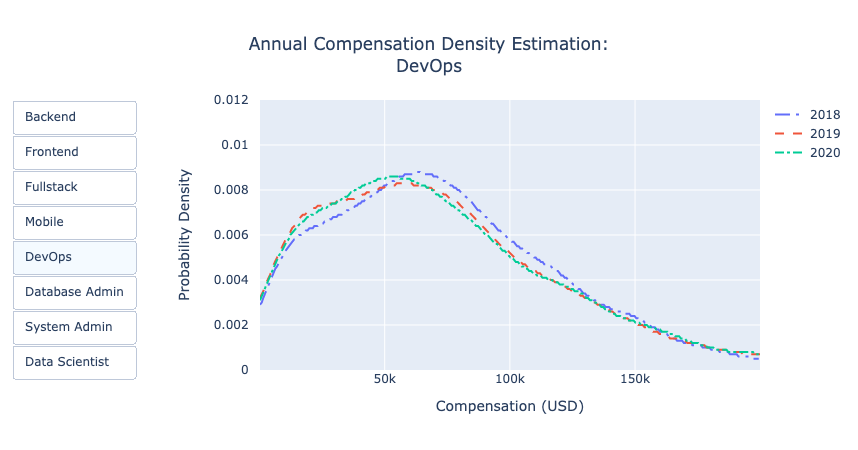

In [56]:
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# initial plot
initial_devtype = list(selected_dev_type_columns.keys())[0]
initial_plot_df = compensation_dev_type_df[compensation_dev_type_df[initial_devtype] == 1]

fig = create_kde_per_devtype(initial_plot_df)

fig_dict['data'] = fig.data
fig_dict['layout'] = fig.layout

# frames
steps = []
for i, dev_type in enumerate(selected_dev_type_columns):
    if i>7: break
    frame = {"name": dev_type}
    
    dev_type_compensation = compensation_dev_type_df[(compensation_dev_type_df[dev_type] == 1)]

    fig = create_kde_per_devtype(dev_type_compensation)
    fig = update_kde_layout(fig, dev_type)

    frame['data'] = fig.data
    frame['layout'] = fig.layout

    fig_dict["frames"].append(frame)

    slider_step = {
        "label": selected_dev_type_columns[dev_type],
        "method": "animate",
        "args": [
            [dev_type],
            {"frame": {"duration": 300, "redraw": True},
             "mode": "immediate",
             "transition": {"duration": 300}}
        ],
    }
    steps.append(slider_step)

fig_dict['layout']["updatemenus"] = [dict(
    type="buttons",
    pad={"r": 100, },#"t": -80},
    buttons=steps
)]

fig = go.Figure(fig_dict)
fig = update_kde_layout(fig, initial_devtype)

fig.show()

![image.png](images/compensation_per_developer_density_viz.png)

[Link to interactive viz](https://chart-studio.plotly.com/~masharo/88/#/)

In [57]:
py.plot(fig, filename = 'stack-overflow-kde-salary-plot')

'https://plotly.com/~masharo/88/'

### Average Compensation per Dev Type

In [96]:
avg_df = []
for devtype in selected_dev_type_columns:
    devtype_df = compensation_dev_type_df[compensation_dev_type_df[devtype]==1]
    devtype_df = devtype_df.groupby(['year']).agg({'compensation': 'median'})
    devtype_df.columns = [devtype]
    avg_df.append(devtype_df)

In [97]:
from functools import reduce
join_avg = reduce(lambda df1, df2: pd.merge(df1,df2, on='year'), avg_df)
join_avg

,"Developer, back-end","Developer, front-end","Developer, full-stack","Developer, mobile",DevOps specialist,Database administrator,System administrator,Data scientist or machine learning specialist,Data or business analyst,Engineering manager,Product manager,"Developer, desktop or enterprise applications"
year,,,,,,,,,,,,
2018,55562.0,51408.0,59000.0,43224.0,72469.0,51394.0,55562.0,60000.0,58890.5,88573.0,63174.0,57480.0
2019,55680.0,51559.0,57425.5,44629.5,71036.0,54302.0,55000.0,61071.0,59004.0,95000.0,60000.0,56142.0
2020,52996.0,48600.0,54474.0,43239.0,68068.0,50387.5,54049.0,58000.0,55129.0,91883.0,59000.0,55582.0


In [98]:
avg_devtype_transform = join_avg.T.unstack().reset_index(name='avg_compensation').rename(columns={'level_1':'devtype'})
avg_devtype_transform['devtype_label'] = avg_devtype_transform.devtype.map(selected_dev_type_columns)
# sort by group year and avgerage compensation
avg_devtype_transform = avg_devtype_transform.groupby(
    ['year'], group_keys=False
).apply(
    lambda x: x.sort_values('avg_compensation', ascending=False)
)
avg_devtype_transform.head()

,year,devtype,avg_compensation,devtype_label
9,2018,Engineering manager,88573.0,Engineer Manager
4,2018,DevOps specialist,72469.0,DevOps
10,2018,Product manager,63174.0,Product manager
7,2018,Data scientist or machine learning specialist,60000.0,Data Scientist
2,2018,"Developer, full-stack",59000.0,Fullstack


### Viz - Average Compensation per Dev Type

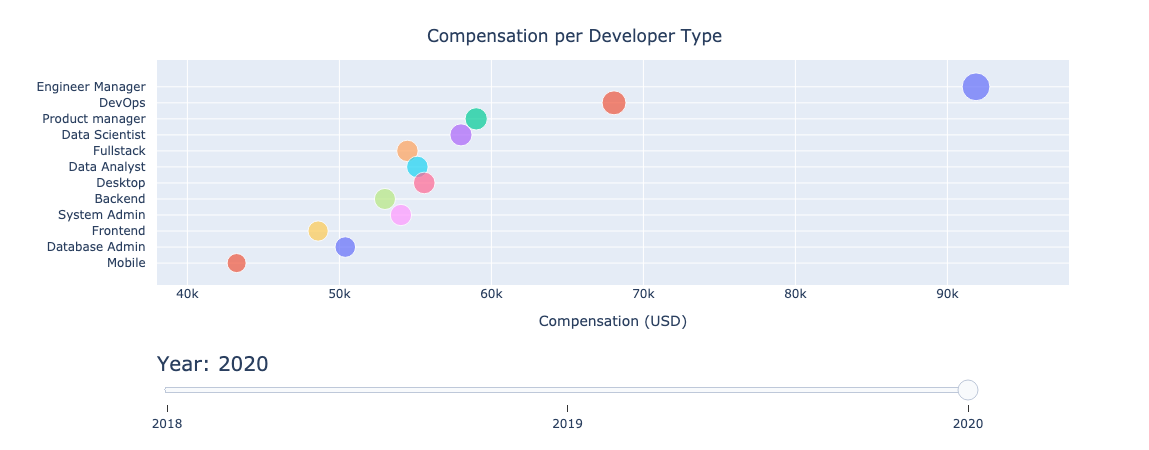

In [102]:
fig = px.scatter(
    avg_devtype_transform, x="avg_compensation", y="devtype_label", animation_frame="year",
    size="avg_compensation", 
    color="devtype_label",
    hover_name='devtype',
    hover_data={
        'devtype_label': False,
        'avg_compensation':':$.3s',
    },
    labels={
        "devtype_label": "Developer Type", 
        "avg_compensation": "Compensation", 
        "year": "Year"
    },
)

for step in range(len(fig.layout.sliders[0].steps)):
    fig.layout.sliders[0].steps[step].args[1]['transition'] = {"duration": 400, "easing": "cubic-in-out"}
    fig.layout.sliders[0].steps[step].args[1]['frame'] = {'duration': 400, 'redraw': False}

# fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 800
# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 800
fig.layout.updatemenus[0].buttons = None

fig.layout.sliders[0]['x'] = 0
fig.layout.sliders[0]['currentvalue'] = {
    "font": {"size": 20},
    "prefix": "Year: ",
    "visible": True,
    "xanchor": "left"
}

# changing default active plot 
last_frame_index = len(fig.layout.sliders[0].steps) - 1
fig.layout.sliders[0]['active'] = last_frame_index
fig.data = None
for data in fig.frames[last_frame_index].data:
    fig.add_trace(data)

fig.update_layout(
    showlegend=False,
    xaxis=dict(
        title='Compensation (USD)',
        range=[38000, 98000]
    ),
    yaxis=dict(
        title='',
        zeroline=False,
        ticks= "outside", 
        tickcolor= 'white', 
        ticklen= 8,
    ),
    title=dict(
        text= "Compensation per Developer Type",
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
)

fig.show()

![image.png](images/compensation_per_developer_average_viz.png)

[Link to interactive viz](https://chart-studio.plotly.com/~masharo/86/)

In [103]:
py.plot(fig, filename = 'stack-overflow-average-compensation-per-devtype-animation')

'https://plotly.com/~masharo/86/'

## Evaluation

From the first viz we could see that the shape of the curves per year remains similar, with a tendency of normalization in lower range salaries.
Depending on the developer type, curves get skewed to lower salaries (Mobile Developers) or better approximating to normally distributed (DevOps).

Furthermore, from the visualization above its clear that Engineer Managers keep reporting the highest annual compensations, with median salaries around 90k USD dollars per year. For the rest of professional developers, salaries range around 55k per year.